In [17]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from great_tables import GT, style, loc, md

In [18]:
files = os.listdir('baseline_merged')
files = [file for file in files if file.endswith('.csv')]

baseline_merged = pd.concat([pd.read_csv(f'baseline_merged/{file}') for file in files])
baseline_merged.dropna(subset='recc_rate', inplace=True)

baseline_merged=baseline_merged[~baseline_merged['User'].isin(['Nathan Worrell','Liam Jagrowski','Henry Cross','Dylan Orr','Jacob Swain','John Hazelton','Brian Dietrich'])]

baseline_merged['InputtedRent'] = baseline_merged['InputtedRent'].str.replace(',','').astype(float)
baseline_merged['RecommendationDate'] = pd.to_datetime(baseline_merged['RecommendationDate'])

AssetDetailActive = pd.read_csv('data/vw_AssetDetailActive.csv')

baseline_merged = baseline_merged.merge(AssetDetailActive, on='AssetName')

baseline_merged['Diff'] = baseline_merged['InputtedRent'] - baseline_merged['recc_rate']

In [19]:
baseline_merged['accepted'] = abs(baseline_merged['InputtedRent'] - baseline_merged['recc_rate']) < 1
baseline_merged['accepted_range'] = (baseline_merged['InputtedRent'] >= baseline_merged['recc_rate_lower']) & (baseline_merged['InputtedRent'] <= baseline_merged['recc_rate_upper'])

rejections = baseline_merged[~baseline_merged['accepted']]
rejections['increase'] = rejections['Diff'] > 0
rejections['decrease'] = rejections['Diff'] < 0

C:\Users\Tyson.King\AppData\Local\Temp\ipykernel_37816\326457472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejections['increase'] = rejections['Diff'] > 0
C:\Users\Tyson.King\AppData\Local\Temp\ipykernel_37816\326457472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejections['decrease'] = rejections['Diff'] < 0


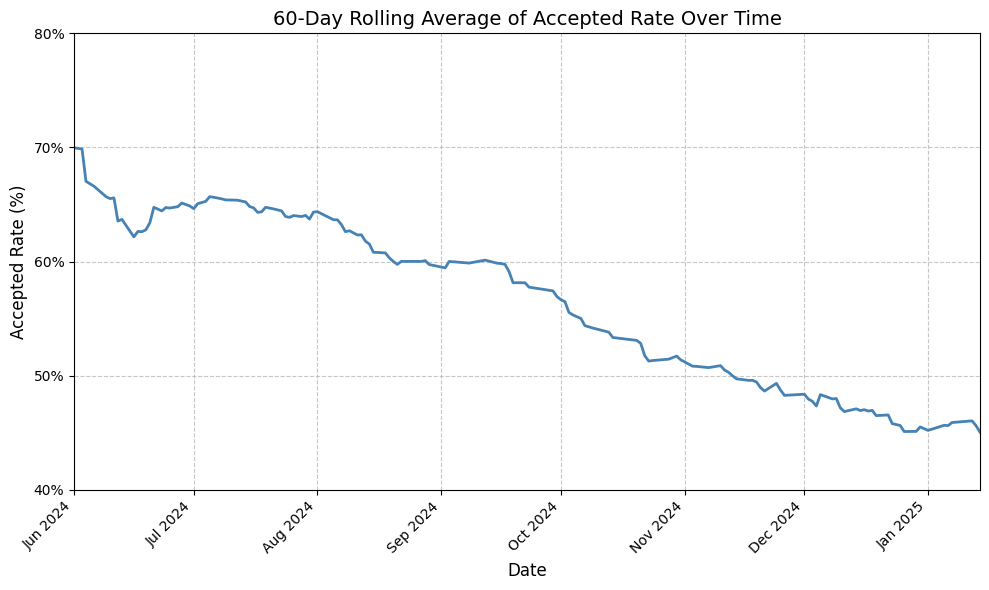

In [20]:
# Calculate daily average of accepted rate
daily_avg = baseline_merged.groupby('RecommendationDate')['accepted_range'].mean()

# Calculate rolling average of accepted rate over time
rolling_avg = daily_avg.rolling(window=60, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_avg, color='steelblue', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accepted Rate (%)', fontsize=12)
plt.title('60-Day Rolling Average of Accepted Rate Over Time', fontsize=14)
plt.xlim(pd.to_datetime('2024-06-01'), max(daily_avg.index))
plt.ylim(0.4, 0.8)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8], ['40%', '50%', '60%', '70%', '80%'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.style.use('seaborn-v0_8-muted')
plt.tight_layout()
plt.show()

In [21]:
accepted_pct = (baseline_merged['accepted_range']).mean()
accepted_pct = round(accepted_pct * 100, 1)

rejected_inc = (rejections['increase']).mean()
rejected_dec = 1 - rejected_inc


rejected_inc = round(rejected_inc * 100, 1)
rejected_dec = round(rejected_dec * 100, 1)

# Print out values for debugging
print(f"Accepted percentage: {accepted_pct}")
print(f"Rejected Increase percentage: {rejected_inc}")
print(f"Rejected Decrease percentage: {rejected_dec}")

Accepted percentage: 52.3
Rejected Increase percentage: 62.3
Rejected Decrease percentage: 37.7


In [22]:
total_adj = len(baseline_merged)

by_reason = baseline_merged.groupby('ChangeReason').agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('count', ascending=False).reset_index()

by_reason['prop'] = by_reason['count'] / total_adj

display(by_reason)

,ChangeReason,count,acceptance_rate,median_adjustment,prop
0,Baseline Rent Accepted,3483,0.844674,0.206242,0.516842
1,Other Action taken (see comment),1242,0.218196,55.193314,0.184300
2,Strong/High trends do not support rent recomme...,1178,0.134975,85.183543,0.174803
3,Soft/Low trends do not support rent recommenda...,398,0.178392,-62.177110,0.059059
4,Low lead conversion,182,0.076923,-58.803515,0.027007
5,Known product issue,73,0.273973,47.662010,0.010832
6,Low lead volume,69,0.333333,12.824892,0.010239
7,Known people issue,58,0.275862,44.791175,0.008607
8,"Cashflow strategy, Elevated occupancy goal v....",32,0.250000,-28.814697,0.004748
9,Change in normal strategy due to dispo,19,0.157895,66.178710,0.002819


In [33]:
by_rm = baseline_merged.groupby(['MarketName']).agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()


display(by_rm)

,MarketName,count,acceptance_rate,median_adjustment
0,"West Palm Beach-Boca Raton-Delray Beach, FL",74,0.716216,-8.072369
1,"Boise City, ID",6,0.666667,13.875475
2,"Nashville-Davidson--Murfreesboro--Franklin, TN",171,0.654971,0.276978
3,"Orlando-Kissimmee-Sanford, FL",417,0.618705,-0.050578
4,"Charlotte-Concord-Gastonia, NC-SC",900,0.582222,0.517292
5,"San Antonio-New Braunfels, TX",31,0.580645,21.306443
6,"Fort Collins, CO",37,0.567568,39.314779
7,"Chicago-Naperville-Elgin, IL-IN-WI",23,0.565217,3.703395
8,"Raleigh/Durham, NC",729,0.558299,16.080071
9,"Miami-Miami Beach-Kendall, FL",52,0.557692,60.990605


In [23]:
# Create a GT object
table = GT(by_reason[['ChangeReason', 'count', 'prop', 'median_adjustment']])

table = (
    table
    .cols_label(ChangeReason = md("**Change Reason**"),
                count = md("**Count**"),
                prop = md("**Proportion**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Selected 'Change Reason'")
    .fmt_currency(columns = 3)
    .fmt_percent(columns = 2)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

GT(_tbl_data=                                         ChangeReason  count      prop  \
0                              Baseline Rent Accepted   3483  0.516842   
1                    Other Action taken (see comment)   1242  0.184300   
2   Strong/High trends do not support rent recomme...   1178  0.174803   
3   Soft/Low trends do not support rent recommenda...    398  0.059059   
4                                 Low lead conversion    182  0.027007   
5                                 Known product issue     73  0.010832   
6                                     Low lead volume     69  0.010239   
7                                  Known people issue     58  0.008607   
8   Cashflow strategy,  Elevated occupancy goal v....     32  0.004748   
9              Change in normal strategy due to dispo     19  0.002819   
10  Known or presumed retention misaligns with pro...      5  0.000742   

    median_adjustment  
0            0.206242  
1           55.193314  
2           85.183543  
3          -62.177110  
4          -58.803515  
5           47.662010  
6           12.824892  
7           44.791175  
8          -28.814697  
9           66.178710  
10          94.458687  , _body=<great_tables._gt_data.Body object at 0x0000013C8097F650>, _boxhead=Boxhead([ColInfo(var='ChangeReason', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Change Reason**'), column_align='left', column_width=None), ColInfo(var='count', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Count**'), column_align='right', column_width=None), ColInfo(var='prop', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Proportion**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000013CDB9A36D0>, _spanners=Spanners([]), _heading=Heading(title="Price Change Metrics by Selected 'Change Reason'", subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=5, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='ChangeReason', rownum=6, colnum

In [24]:
example_comments = baseline_merged[baseline_merged['ChangeReason'] == 'Other Action taken (see comment)'].dropna(subset='Comment').sample(15)['Comment']

# Save comments to a text file with one observation per line and no index
with open('figures/example_comments.txt', 'w') as f:
    for comment in example_comments:
        f.write(comment + '\n')

In [53]:
by_property = baseline_merged.groupby(['AssetName', 'User']).agg(
    count = ('accepted', 'count'),
    acceptance_rate = ('accepted_range', 'mean'),
    median_adjustment = ('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()

by_property = by_property[by_property['count'] > 20]

# Calculate the overall mean acceptance rate
overall_mean_acceptance_rate = baseline_merged['accepted_range'].mean()

# Function to perform the hypothesis test
def perform_hypothesis_test(asset_name, overall_mean):
    # Get the acceptance rates for the current asset
    asset_data = baseline_merged[baseline_merged['AssetName'] == asset_name]['accepted_range']
    
    # Check if there are enough data points to perform the test
    if len(asset_data) > 1:  # We need at least two data points for a valid t-test
        t_stat, p_value = stats.ttest_1samp(asset_data, overall_mean)
        return p_value
    else:
        return float('nan')  # Return NaN if not enough data to perform t-test


# Apply the hypothesis test for each market and store the results in a new column 'p_value'
by_property['p_value'] = by_property['AssetName'].apply(lambda x: perform_hypothesis_test(x, overall_mean_acceptance_rate))

# Adding a new column 'is_significant' to indicate if p-value is less than 0.05 (95% confidence)
by_property['is_significant'] = by_property['p_value'] < 0.05

by_property = by_property[['AssetName', 'User', 'acceptance_rate', 'median_adjustment', 'count', 'p_value', 'is_significant']]

# Filter markets that are significantly different from the overall mean (p-value < 0.05)
significant_properties = by_property[by_property['is_significant']]

below_average_properties = significant_properties[significant_properties['acceptance_rate'] < overall_mean_acceptance_rate]

# Drop 'p_value' and 'is_significant' columns
below_average_properties = below_average_properties.drop(columns=['count', 'p_value', 'is_significant']).tail(10)

# Create a GT object
table = GT(below_average_properties)

table = (
    table
    .cols_label(AssetName = md("**Property**"),
                User = md("**RM**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Property",
                subtitle = "(Properties with Significantly Low Acceptance Rate)")
    .fmt_currency(columns = 3)
    .fmt_percent(columns = 2)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

GT(_tbl_data=                      AssetName           User  acceptance_rate  \
224  Cortland Duluth - Phase 2A      Zack Knab         0.325301   
225     Cortland Cary - Phase 1  Melissa Jones         0.305556   
232         Cortland at Coalton  Joshua Bivens         0.282609   
234         Cortland West Plano     Ruchi Naik         0.260870   
239  Cortland Rosslyn - Phase 2  Melissa Jones         0.250000   
241           Cortland Cap Hill  Joshua Bivens         0.250000   
250      Cortland Congress Park  Joshua Bivens         0.241379   
253    Cortland Covington Ridge  Joshua Bivens         0.230769   
255     Cortland at Twin Creeks     Ruchi Naik         0.222222   
275          Cortland Northlake  Melissa Jones         0.075758   

     median_adjustment  
224          56.512367  
225          60.317795  
232          96.031839  
234          21.632811  
239          86.032578  
241          89.106730  
250          93.293287  
253          75.442288  
255          56.486410  
275          83.297185  , _body=<great_tables._gt_data.Body object at 0x0000013CE02A4C50>, _boxhead=Boxhead([ColInfo(var='AssetName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Property**'), column_align='left', column_width=None), ColInfo(var='User', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**RM**'), column_align='left', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000013CE0237550>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Property', subtitle='(Properties with Significantly Low Acceptance Rate)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=5, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='AssetName', rownum=6, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, tr

In [26]:
baseline_merged['AcquisitionDate_numeric'] = pd.to_datetime(baseline_merged['AcquisitionDate']).astype(int) / 10**9

# Perform the aggregation
by_market = baseline_merged.groupby(['MarketName']).agg(
    count=('accepted', 'count'),
    acceptance_rate=('accepted_range', 'mean'),
    num_assets=('AssetName', 'nunique'),
    acquisition_date_numeric=('AcquisitionDate_numeric', 'min'),
    median_adjustment=('Diff', 'median')
).sort_values('acceptance_rate', ascending=False).reset_index()

# Convert the numeric values back to dates
by_market['acquisition_date'] = pd.to_datetime(by_market['acquisition_date_numeric'], unit='s')
by_market.drop(columns=['acquisition_date_numeric'], inplace=True)

# Function to perform the hypothesis test
def perform_hypothesis_test(market_name, overall_mean):
    # Get the acceptance rates for the current market
    market_data = baseline_merged[baseline_merged['MarketName'] == market_name]['accepted_range']
    
    # Check if there are enough data points to perform the test
    if len(market_data) > 1:  # We need at least two data points for a valid t-test
        t_stat, p_value = stats.ttest_1samp(market_data, overall_mean)
        return p_value
    else:
        return float('nan')  # Return NaN if not enough data to perform t-test

# Apply the hypothesis test for each market and store the results in a new column 'p_value'
by_market['p_value'] = by_market['MarketName'].apply(lambda x: perform_hypothesis_test(x, overall_mean_acceptance_rate))

# Adding a new column 'is_significant' to indicate if p-value is less than 0.05 (95% confidence)
by_market['is_significant'] = by_market['p_value'] < 0.05

by_market = by_market[['MarketName', 'num_assets', 'acquisition_date', 'acceptance_rate', 'median_adjustment', 'count', 'p_value', 'is_significant']]

# Filter markets that are significantly different from the overall mean (p-value < 0.05)
significant_markets = by_market[by_market['is_significant']]

below_average_markets = significant_markets[significant_markets['acceptance_rate'] < overall_mean_acceptance_rate]

# Drop 'p_value' and 'is_significant' columns
below_average_markets = below_average_markets.drop(columns=['count', 'p_value', 'is_significant'])

# Create a GT object
table = GT(below_average_markets)

table = (
    table
    .cols_label(MarketName = md("**Market**"),
                num_assets = md("**# Assets**"),
                acquisition_date = md("**Earliest Acquisition**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Market",
                subtitle = "(Markets with Significantly Low Acceptance Rate)")
    .fmt_currency(columns = 4)
    .fmt_percent(columns = 3)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

# Display the table
# table.save('figures/low_acc_bymarket.png')


GT(_tbl_data=                                      MarketName  num_assets acquisition_date  \
17  Washington-Arlington-Alexandria, DC-VA-MD-WV           5       2022-05-17   
19                      Fort Worth-Arlington, TX          11       2014-02-07   
20                    Denver-Aurora-Lakewood, CO          15       2017-12-19   
21                                    Tucson, AZ           5       2021-08-16   
24                   Phoenix-Mesa-Scottsdale, AZ          14       2019-03-11   
25                          Colorado Springs, CO           5       2016-11-30   

    acceptance_rate  median_adjustment  
17         0.427419          50.997448  
19         0.400000          43.411099  
20         0.389728          52.821859  
21         0.375000          36.932556  
24         0.284360          38.866484  
25         0.260870          48.709473  , _body=<great_tables._gt_data.Body object at 0x0000013CDBCF78D0>, _boxhead=Boxhead([ColInfo(var='MarketName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Market**'), column_align='left', column_width=None), ColInfo(var='num_assets', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**# Assets**'), column_align='right', column_width=None), ColInfo(var='acquisition_date', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Earliest Acquisition**'), column_align='right', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000013CDBCF7AD0>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Market', subtitle='(Markets with Significantly Low Acceptance Rate)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=5, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)])], _locale=<great_tables._gt_data.Locale object at 0x0000013CDBD07810>, _formats=[<great_tables._gt_data.FormatInfo object at 0x0000013CDBB95990>, <great_tables._gt_data.FormatInfo object at 0x0000013CDBB94850>], _substitutions=[], _options=Options

In [52]:
# Create a GT object
table = GT(by_market.drop(columns=['count', 'p_value', 'is_significant']))

table = (
    table
    .cols_label(MarketName = md("**Market**"),
                num_assets = md("**# Assets**"),
                acquisition_date = md("**Earliest Acquisition**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Market")
    .fmt_currency(columns = 4)
    .fmt_percent(columns = 3)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

# Display the table
table.save('figures/acc_bymarket.png')

GT(_tbl_data=                                           MarketName  num_assets  \
0         West Palm Beach-Boca Raton-Delray Beach, FL           6   
1                                      Boise City, ID           2   
2      Nashville-Davidson--Murfreesboro--Franklin, TN           3   
3                       Orlando-Kissimmee-Sanford, FL          14   
4                   Charlotte-Concord-Gastonia, NC-SC          11   
5                       San Antonio-New Braunfels, TX           5   
6                                    Fort Collins, CO           1   
7                  Chicago-Naperville-Elgin, IL-IN-WI           1   
8                                  Raleigh/Durham, NC          11   
9                       Miami-Miami Beach-Kendall, FL           6   
10                Tampa-St. Petersburg-Clearwater, FL          13   
11                  Atlanta-Sandy Springs-Roswell, GA          36   
12                                       Columbus, OH          14   
13                            Dallas-Plano-Irving, TX          31   
14               Houston-The Woodlands-Sugar Land, TX          13   
15  Fort Lauderdale-Pompano Beach-Deerfield Beach, FL           4   
16                              Austin-Round Rock, TX           6   
17       Washington-Arlington-Alexandria, DC-VA-MD-WV           5   
18             Deltona-Daytona Beach-Ormond Beach, FL           1   
19                           Fort Worth-Arlington, TX          11   
20                         Denver-Aurora-Lakewood, CO          15   
21                                         Tucson, AZ           5   
22                              Birmingham-Hoover, AL           1   
23                          Lakeland-Winter Haven, FL           1   
24                        Phoenix-Mesa-Scottsdale, AZ          14   
25                               Colorado Springs, CO           5   

   acquisition_date  acceptance_rate  median_adjustment  
0        2020-07-23         0.716216          -8.072369  
1        2022-05-12         0.666667          13.875475  
2        2021-09-16         0.654971           0.276978  
3        2018-07-17         0.618705          -0.050578  
4        2017-09-29         0.582222           0.517292  
5        2019-09-27         0.580645          21.306443  
6        2021-05-25         0.567568          39.314779  
7        2022-06-28         0.565217           3.703395  
8        2018-01-19         0.558299          16.080071  
9        2021-08-24         0.557692          60.990605  
10       2019-04-01         0.542169          41.257213  
11       2016-12-31         0.526495          28.688187  
12       2014-09-30         0.516667          -0.396400  
13       2017-07-31         0.515101          22.327212  
14       2017-06-27         0.500000           3.528227  
15       2021-01-06         0.483871          60.485004  
16       2017-07-28         0.441860          21.876714  
17       2022-05-17         0.427419          50.997448  
18       2021-08-24         0.408163          19.405843  
19       2014-02-07         0.400000          43.411099  
20       2017-12-19         0.389728          52.821859  
21       2021-08-16         0.375000          36.932556  
22       2017-06-22         0.333333          50.578124  
23       2021-07-09         0.300000         -72.014037  
24       2019-03-11         0.284360          38.866484  
25       2016-11-30         0.260870          48.709473  , _body=<great_tables._gt_data.Body object at 0x0000013CE02EAD90>, _boxhead=Boxhead([ColInfo(var='MarketName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Market**'), column_align='left', column_width=None), ColInfo(var='num_assets', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**# Assets**'), column_align='right', column_width=None), ColInfo(var='acquisition_date', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Earliest Acquisition**'), column_align='right', column_width=None), ColInfo(var='acceptance_rate', type

In [29]:
above_average_markets = significant_markets[significant_markets['acceptance_rate'] > overall_mean_acceptance_rate]

# Drop 'p_value' and 'is_significant' columns
above_average_markets = above_average_markets.drop(columns=['count', 'p_value', 'is_significant'])

# Create a GT object
table = GT(above_average_markets)

table = (
    table
    .cols_label(MarketName = md("**Market**"),
                num_assets = md("**# Assets**"),
                acquisition_date = md("**Earliest Acquisition**"),
                acceptance_rate = md("**Acceptance Rate**"),
                median_adjustment = md("**Median Adjustment**"))
    .tab_header(title = "Price Change Metrics by Market",
                subtitle = "(Markets with Significantly Low Acceptance Rate)")
    .fmt_currency(columns = 4)
    .fmt_percent(columns = 3)
    .tab_style(
        style=style.text(style="italic"),
        locations = loc.body(columns=0)
    )
)

table

# table.save('figures/high_acc_bymarket.png')


GT(_tbl_data=                                       MarketName  num_assets  \
0     West Palm Beach-Boca Raton-Delray Beach, FL           6   
2  Nashville-Davidson--Murfreesboro--Franklin, TN           3   
3                   Orlando-Kissimmee-Sanford, FL          14   
4               Charlotte-Concord-Gastonia, NC-SC          11   

  acquisition_date  acceptance_rate  median_adjustment  
0       2020-07-23         0.716216          -8.072369  
2       2021-09-16         0.654971           0.276978  
3       2018-07-17         0.618705          -0.050578  
4       2017-09-29         0.582222           0.517292  , _body=<great_tables._gt_data.Body object at 0x0000013CD97582D0>, _boxhead=Boxhead([ColInfo(var='MarketName', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Market**'), column_align='left', column_width=None), ColInfo(var='num_assets', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**# Assets**'), column_align='right', column_width=None), ColInfo(var='acquisition_date', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Earliest Acquisition**'), column_align='right', column_width=None), ColInfo(var='acceptance_rate', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Acceptance Rate**'), column_align='right', column_width=None), ColInfo(var='median_adjustment', type=<ColInfoTypeEnum.default: 1>, column_label=Md(text='**Median Adjustment**'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000013CDBBDC090>, _spanners=Spanners([]), _heading=Heading(title='Price Change Metrics by Market', subtitle='(Markets with Significantly Low Acceptance Rate)', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=0, rows=None, mask=None), grpname=None, colname='MarketName', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)])], _locale=<great_tables._gt_data.Locale object at 0x0000013C80972010>, _formats=[<great_tables._gt_data.FormatInfo object at 0x0000013CDBD0A0D0>, <great_tables._gt_data.FormatInfo object at 0x0000013CDB9F3790>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', '

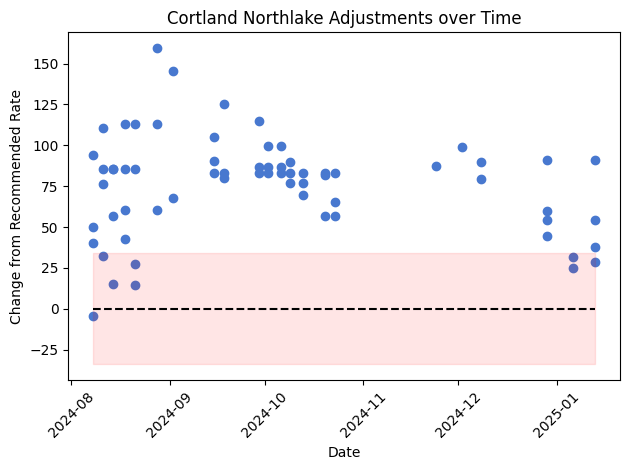

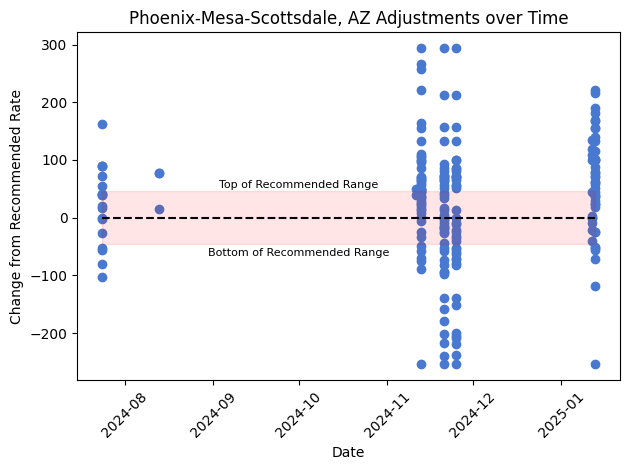

In [47]:
def get_adj_over_time(asset_name=None, market_name=None):

    if asset_name:
        filtered = baseline_merged[baseline_merged['AssetName'] == asset_name]
    elif market_name:
        filtered = baseline_merged[baseline_merged['MarketName'] == market_name]

    filtered = filtered.sort_values('RecommendationDate').reset_index()

    avg_range = (filtered['recc_rate'] - filtered['recc_rate_lower']).mean()

    plt.scatter(filtered['RecommendationDate'], filtered['Diff'])
    plt.xlabel("Date")
    plt.ylabel("Change from Recommended Rate")

    if asset_name:
        plt.title(f"{asset_name} Adjustments over Time")
    elif market_name:
        plt.title(f"{market_name} Adjustments over Time")
    
    plt.fill_between(filtered['RecommendationDate'], -avg_range, avg_range, color='red', alpha=0.1)
    plt.hlines(0, min(filtered['RecommendationDate']), max(filtered['RecommendationDate']), linestyles="dashed", colors="black")
    plt.xticks(rotation=45)
    if market_name == "Phoenix-Mesa-Scottsdale, AZ":
        plt.text(x=pd.to_datetime('2024-10-01'), y=avg_range + 5, s="Top of Recommended Range", size=8, ha='center')
        plt.text(x=pd.to_datetime('2024-10-01'), y=-avg_range - 20, s="Bottom of Recommended Range", size=8, ha='center')
    plt.style.use('seaborn-v0_8-muted')
    plt.tight_layout()
    if asset_name:
        plt.savefig(f'figures/adj_over_time/{asset_name}')
    elif market_name:
        plt.savefig(f'figures/adj_over_time/{market_name}')
    
    plt.show()
    

get_adj_over_time(asset_name="Cortland Northlake")
# get_adj_over_time(asset_name="Cortland 3131")
get_adj_over_time(market_name="Phoenix-Mesa-Scottsdale, AZ")
# get_adj_over_time(market_name="West Palm Beach-Boca Raton-Delray Beach, FL")
# get_adj_over_time(market_name="Denver-Aurora-Lakewood, CO")
# get_adj_over_time(market_name="Colorado Springs, CO")